## Deep Learning von Baumarten mit hochauflösenden RGB-Drohnendaten

> author: Bastian Schäfers & Jonathan Sommer
> 
> date: 26.08.2024


### Zielstellung

In dieser Hausarbeit versuchen wir mit Hilfe sehr hoch aufgelöster RGB-Daten (3 cm), fünf Baumarten anhand ihrer charakteristischen Baumkronen zu unterscheiden. Zur Klassifizierung nutzen wir ein Multi-Layer-Perzeptron (MLP).
__________________________________________________________________________________________________________________________________

### Installation benötigter Packages & Import von Libraries

In [1]:
#pip install matplotlib-scalebar

In [ ]:
#pip install contextily

In [ ]:
#pip install plotly

In [1]:
## LIBRARIES

# BASICS
import cv2
import numpy as np
import random
import os, sys
import pandas as pd
import xarray as xr
import rioxarray as rxr
import seaborn as sns
import glob

# RASTERDATEN
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterio.plot import show
from PIL import Image

# VEKTORDATEN
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import box

# KARTEN & PLOTS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from collections import Counter
import plotly.graph_objects as go
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D

# DEEP LEARNING 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [2]:
## WORKING DIRECTORY
print(os.getcwd())
os.chdir('data')
print(os.getcwd())

C:\Users\johnn\KI_Landnutzung\Hausarbeit
C:\Users\johnn\KI_Landnutzung\Hausarbeit\data


### Untersuchungsgebiet
Unser Untersuchungsgebiet befindet sich 5km nordwestlich des Ortes Demmin (4m ü NHN) im Landkreis Mecklenburgischen Seenplatte. Das Gebiet liegt ungefähr 150km nördlich von Berlin im zentralen Mecklenburg-Vorpommern. Der Untersuchungsplot hat eine größe von 6ha und beherbergt im Zentrum den permanenten Untersuchungsplot des FG Geoinformation. Dort werden seit einem Jahr im Rahmen des Forschungsprojekts FeMoPhys (https://www.tu.berlin/geoinformation/forschung/projekte/laufende-projekte/femophys) phenologische Untersuchungen in der Baumkrone durchgeführt. 

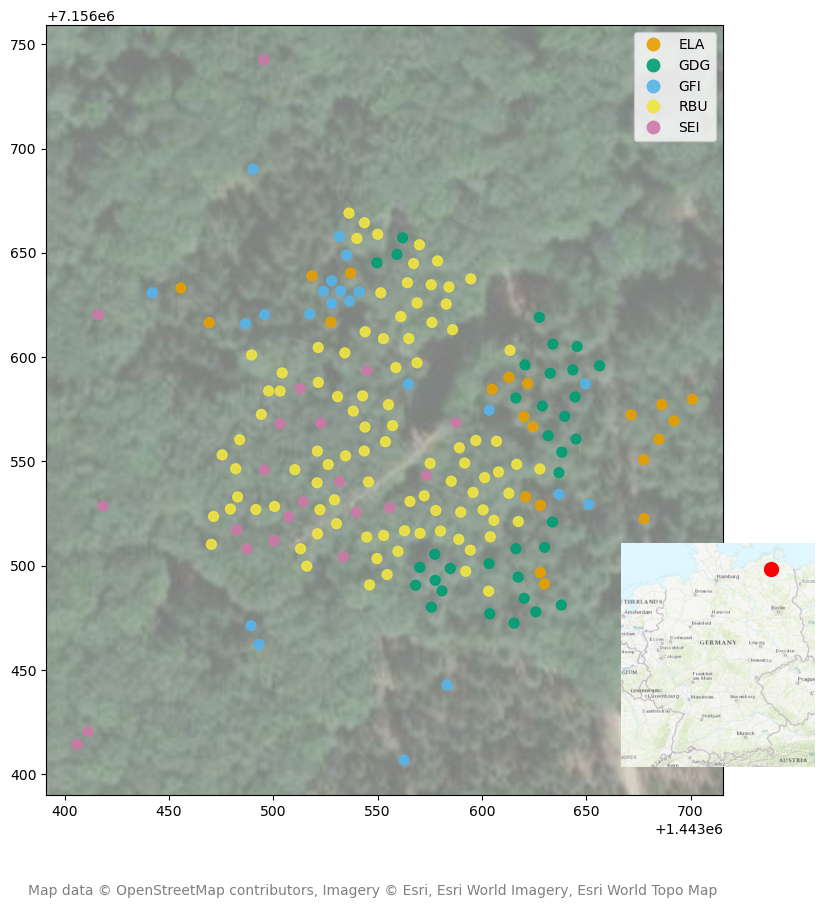

In [3]:
# Zentroiden der Baumkronendaten
samples = gpd.read_file("centroid_1408.shp")  # Point shapefile

# Reprojizieren zu EPSG:3857
samples = samples.to_crs(epsg=3857)

# Umriss der Samples
minx, miny, maxx, maxy = samples.total_bounds

# Bounding Box der Samples
bb = box(minx, miny, maxx, maxy)

# 200-Meter-Puffer um Bounding Box
bb = bb.buffer(200)

# Konvertieren zu GeoDataFrame
bb_gdf = gpd.GeoDataFrame([1], geometry=[bb], crs=samples.crs)

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(10, 10))

# Farbpalette für Baumarten
colors = ["#E69F00", "#009E73", "#56B4E9", "#F0E442", "#CC79A7"]
cmap = mcolors.ListedColormap(colors)

# Plotten der Samples mit Farbpalette 
samples.plot(ax=ax, column='Baumart', cmap=cmap, legend=True, markersize=50, alpha=0.9)

# Hintergrundkarte abrufen
ctx.add_basemap(ax, crs=bb_gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, zoom=17, alpha = 0.5, attribution=False)

# Skala einfügen
#scalebar = ScaleBar(1, location='lower left')  
#ax.add_artist(scalebar)

# Übersichtskarte
ax_inset = inset_axes(ax, width="45%", height="45%", loc='right',
                      bbox_to_anchor=(0, 0, 1.1, 0.5), bbox_transform=ax.figure.transFigure)

bb_gdf.boundary.plot(ax=ax_inset, linewidth=1, edgecolor='black')

uebersicht = {
    'minx': 528332.7395,  # Koordinaten der BBox für die Übersichtskarte
    'miny': 5948635.2893,
    'maxx': 1709743.4487,
    'maxy': 7320832.8210
}
# 528332.7395,5948635.2893,1709743.4487,7320832.8210
bounds_gdf = gpd.GeoDataFrame(
    geometry=[box(uebersicht['minx'], uebersicht['miny'], 
                  uebersicht['maxx'], uebersicht['maxy'])]
)

bounds = bounds_gdf.total_bounds  

ax_inset.set_xlim(bounds[0], bounds[2])
ax_inset.set_ylim(bounds[1], bounds[3])

# Topographische Hintergrundkarte 
ctx.add_basemap(ax_inset, crs=bb_gdf.crs.to_string(), source=ctx.providers.Esri.WorldTopoMap, zoom=6, attribution=False)

roi_center = [(minx + maxx) / 2, (miny + maxy) / 2]
ax_inset.plot(roi_center[0], roi_center[1], 'ro', markersize=10, label="Study Area")

#ax.set_axis_off()
ax_inset.set_axis_off()

fig.text(0.5, 0.01, 'Map data © OpenStreetMap contributors, Imagery © Esri, Esri World Imagery, Esri World Topo Map', 
         ha='center', fontsize=10, color='gray')

plt.show()

***Abbildung 2***: Lage und Verteilung der Samples im Untersuchungsgebiet sowie im größeren geographischen Kontext. 
Zur übersichtlichen Darstellung wird pro deliniierter Krone nur der Zentroid des jeweiligen Polygons als Punkt gezeigt.

_____________________________________________________________________________________________________________________________________________

### Daten & Methodik

#### Trainings- und Testdaten 


Die Daten stammen von einem permanenten Versuchsplot des FG Geoinformation in Demmin (MV). Aufgenommen wurden sie mit einer Micasense Altum, die an eine Drohne montiert war. 192 Baumkronen wurden per Bildinterpretation deliniert und insgesamt fünf Baumarten zugewiesen, darunter drei Nadel- (Europäische Lärche ELA, Grüne Douglasie GDG, Gemeine Fichte GFI) und zwei Laubbäume (Rotbuche RBU, Stieleiche SEI). RBU ist mit 93 Kronen am häufigsten vertreten, gefolgt von GDG (n = 35), GFI (n = 22) sowie SEI und ELA (n = 21). Die Ungleichverteilung der Stichproben haben wir adressiert, indem wir die Anzahl pro Baumart jeweils auf 20 beschränkt haben. Fast alle Samples befinden sich in einem Cluster in der Mitte des Untersuchungsgebiets. Das liegt daran, dass nur in diesem Gebiet alle fünf Baumarten nebeneinander vorkommen (deswegen wurde diese Fläche als permanenter Untersuchungsplot ausgewählt). Alle anderen Bereiche sind sehr deutlich von einer Baumart dominiert. 

##### *Visualisierung*


Um vorab bewerten zu können, inwieweit die Arten nur auf Grundlage der spektralen Charakteristika zu unterscheiden sind, erstellen wir einen Feature Space Plot, der die Verteilung der Pixelwerte der drei Bänder (Blau, Grün, Rot) auf drei Achsen plottet. 

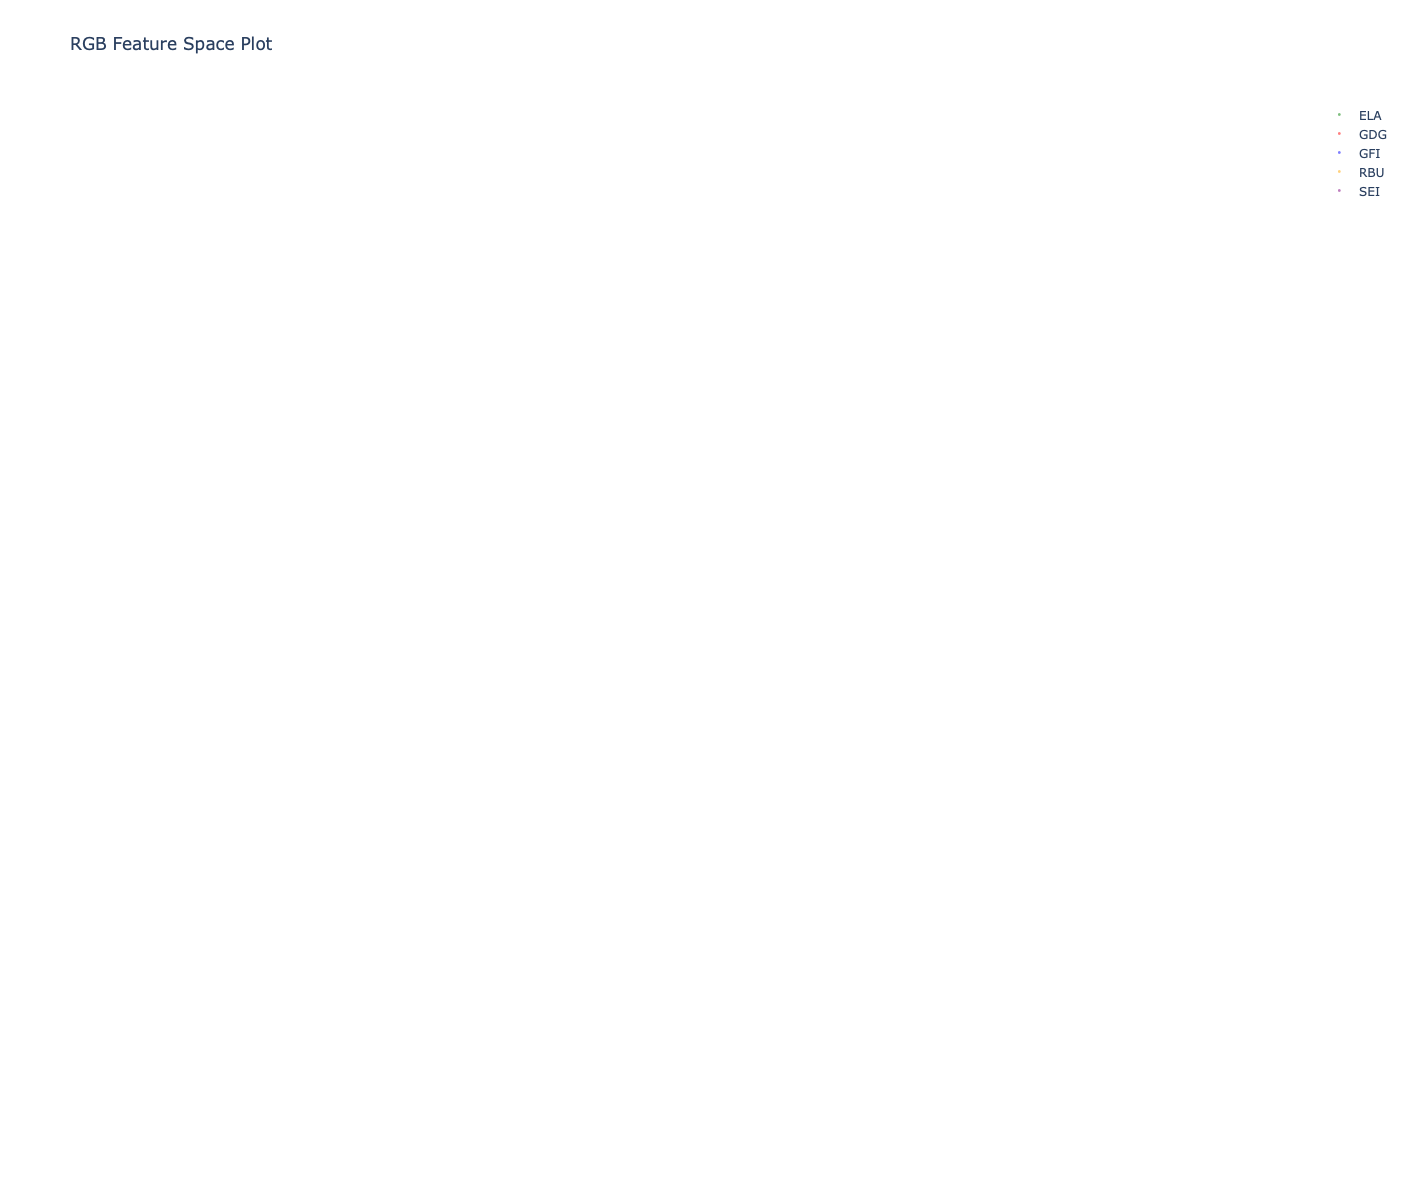

In [4]:
# Pfade zu RGB-Orthomosaic & Polygondatensatz mit delinierten Baumkronen
tif_path = '20230525_Demmin_Altum_orthomosaic_RGB_3cm_georefGCP.tif'
shp_path = 'Kronendelinierung_1408.shp'

# Einladen der Baumkronen mit Baumartlabel
tree_crowns = gpd.read_file(shp_path)

# Funktion zur Extrahierung der Pixelwerte für jedes Polygon (Baumkrone)
def extract_pixel_values(src, polygons):
    values = []
    for polygon in polygons:
        out_image, out_transform = mask(src, [polygon], crop=True) # Ausstanzen des Rasters mit den Polygonen
        out_image = out_image.astype(np.float32)
        out_image[out_image == src.nodata] = np.nan  # Filtern der Pixel ohne Daten
        valid_pixels = out_image[:, ~np.isnan(out_image).any(axis=0)]  # Entfernen der Pixel ohne Daten
        valid_pixels = valid_pixels[:, ~np.all(valid_pixels == 0, axis=0)]  # Entfernen der Pixel mit Nullwerten
        if valid_pixels.size > 0:
            values.append(valid_pixels)
    return np.concatenate(values, axis=1) if values else np.empty((src.count, 0))

# Bei Bedarf könnte man mit folgender Funktion die Außreißer (x < oder > 1.5*IQR)
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Zuweisung aller Pixelwerte zur jeweiligen Baumart
species_pixel_values = {}
species_list = ['ELA', 'GDG', 'GFI', 'RBU', 'SEI']

with rasterio.open(tif_path) as src:
    for species in species_list:
        species_data = tree_crowns[tree_crowns['Baumart'] == species]
        species_polygons = species_data.geometry
        pixel_values = extract_pixel_values(src, species_polygons)
        if pixel_values.shape[1] > 2500:  
            indices = np.random.choice(pixel_values.shape[1], 2500, replace=False)
            pixel_values = pixel_values[:, indices]
        species_pixel_values[species] = pixel_values

# Auswahl der zu betrachtenden Bänder
specific_bands = [0, 1, 2]  # 0 = "Rot", 1 = "Grün, 2 = "Blau"

# Zur besseren Veranschaulichung der Feature Spaces, nutzen wir hier das Package "plotly" um einen interaktiven 3D-Plot zu erstellen
fig = go.Figure()

# Define colors for each species
colors = {'ELA': 'green', 'GDG': 'red', 'GFI': 'blue', 'RBU': 'orange', 'SEI': 'purple'}

# Plotten der Daten für jede Art
for species in species_list:
    if species_pixel_values[species].size > 0:
        x = species_pixel_values[species][specific_bands[0]]
        y = species_pixel_values[species][specific_bands[1]]
        z = species_pixel_values[species][specific_bands[2]]

        # Optionales Entfernen der Ausreißer
        #x = remove_outliers_iqr(x)
        #y = remove_outliers_iqr(y)
        #z = remove_outliers_iqr(z)

        if x.size > 0 and y.size > 0 and z.size > 0:
            min_size = min(x.size, y.size, z.size)
            indices_x = np.random.choice(x.size, min(min_size, 2000), replace=False)
            indices_y = np.random.choice(y.size, min(min_size, 2000), replace=False)
            indices_z = np.random.choice(z.size, min(min_size, 2000), replace=False)

            indices = np.intersect1d(np.intersect1d(indices_x, indices_y), indices_z)
            x = x[indices]
            y = y[indices]
            z = z[indices]

            # Hinzufügen der baumartspezifischen Punktwolken
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(size=3, color=colors[species], opacity=0.5),
                name=species
            ))


# Layout mit Artlabeln, Achsenbeschriftung und Titel
fig.update_layout(
    scene=dict(
        xaxis_title="Red",
        yaxis_title="Green",
        zaxis_title="Blue"
    ),
    title="RGB Feature Space Plot",
    width=1200,  
    height=1200  
)
# Darstellung als interaktiver 3D-Plot
fig.show()

<div>
    <!-- Embed plotly plot here -->
    <div id="plotly-plot"></div>
    <p><strong>Abbbildung 3:</strong> Dieser Plot zeigt die Verteilung der Pixelwerte nach Baumarten im dreidimensionalen Feature Space, wobei der Wert des roten Kanals durch die x-Achse, der Wert des grünen Kanals durch y-Achse und der des blauen Kanals durch die z-Achse repräsentiert wird.</p>
</div>

**Beschreibung der Feature Spaces**

Der obige Plot zeigt, dass sich die RGB-Pixelwerte für die einzelnen Baumarten unterschiedlich gut voneinander unterscheiden lassen. Fichte (GFI; blau) und Stieleiche (SEI; violett) lassen sich am besten voneinander trennen. Die Pixelwerte der Fichtenkronen weisen dabei die höchsten Blau- und die niedrigsten Rotwerte auf. Umgekehrtes gilt für die Kronen die Stieleiche. Die drei anderen Arten bewegen sich zwischen diesen beiden Extremen, wobei Douglasie (GDG; rot) und Lärche (ELA; grün) erwartbar mehr Überschneidung mit Fichte (Nadelbäume) zeigt und die Rotbuche (RBU; orange) mehr Richtung der Wertebereiche der Stieleiche tendiert.

#### Multi-Layer-Perzeptron

##### Hintergrund
Künstliche Neuronen gehören zu den ersten Beispielen von maschinellem Lernen und hatten ihre Anfänge in den in den 1940er-Jahren, als *McCulloch und Pitts* (1943) ein Modell der Funktionsweise des Gehirn nachbildeten. 


Das von ihnen geschaffene künstliche Neuron war ein einfaches lineares Modell, das basierend auf seinen Inputs und verschiededen Gewichten einen negativen oder einen positiven Output generierte (siehe Abbildung 4). Die Gewichte mussten allerdings vorher bestimmt werden, das Neuron war also nicht lernfähig. Diese Weiterentwicklung gelang in den 1950er-Jahren, als das Perzeptron geboren wurde (Rosenblatt, 1957). Dieses war in der Lage, die Gewichte auf Grundlage der Inputs anzupassen. Dazu werden die Inputs und zufällig gewählte Gewichte kombiniert, die gewichtete Summe (weighted sum) ermittelt und dann evaluiert, ob dieser Wert den binären Threshold, die sogenannte Aktivierungsfunktion, überschreitet und das Neuron schießt oder nicht.

Ist dies der Fall, zeigt der Output 1 die Zugehörigkeit zu einer Klasse an, andernfalls zeigt eine 0 die Zugehörigkeit zu einer anderen Klasse an (siehe Abbildung 5, rechts). Je mehr Inputs das Modell erhält, desto feiner werden die Gewichte angepasst, um einen linearen Ausdruck für die Entscheidungsgrenze (eine Hyperebene) zwischen zwei Klassen zu finden. Um die Distanz zwischen der Hyperebene und falsch klassifizierten Punkten zu optimieren, nutzt das Perzeptron das sogenannte Stochastic Gradient Descent (SGD). Dabei lernt das Modell schrittweise die optimale Kombination aus Gewichten. 

Mit nicht-linearen Daten kann das Single-Layer-Perzeptron (SLP) allerdings nicht arbeiten. Aus diesem Grund wurde das Multi-Layer-Perzeptron (MLP) entwickelt (Hinton, 1989). Wie beim SLP, wird aus den Inputs und den initialen Gewichten die gewichtete Summe berechnet und in den ersten versteckten Layer weitergegeben. Im Unterschied zum SLP, muss die Aktivierungsfunktion des MLP nicht Threshold-basiert sein. Denn in der Feedforward-Phase des Modelltrainings wird jede lineare Kombination im Input durch alle versteckten Layer bis in den Output Layer geleitet. Anschließend durchläuft das Modell die Backpropagation, wobei die Gewichte und der Modellbias angepasst werden. Hier wird wieder das SGD eingesetzt. In jeder Iteration, nachdem die gewichteten Summen durch alle Layer weitergeleitet wurden, wird der Gradient des mittleren quadratischen Fehlers (RMSE) für alle Eingabe- und Ausgabepaare berechnet. Der Wert dieses Gradienten wird dann zur Anpassung der Gewichte in den ersten Layer zurückgeleitet. Dieses Prozedere wird wiederholt, bis der Gradient für alle Input Layer konvergiert ist. 

##### MLP in Python (scikit-learn)
Für diese Arbeit haben wir die Python-Implentierung MLPClassifier (version 0.18) aus dem Package 'sklearn.neural_network' verwendet (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#mlpclassifier). Hier wird statt des SGD im default-Modus der 'Stochastic gradient-based optimizer' ADAM (Kingma & Lei Ba, 2017) zur Optimierung der Gewichte genutzt.

##### Sampling-Strategie
Auch wenn die Baumkronen sehr genau deliniert sind, nutzen wir für unsere Samples identische Bounding Boxes, deren Größe sich an der kleinsten Baumkrone orientiert. Dafür haben wir aus allen ursprünglichen Geometrien die Zentroide abgeleitet und davon ausgehend die Bounding Boxes erstellt. Mit diesen haben wir schließlich jede Baumkrone in gleichen Abständen um den Zentroiden aus dem Ausgangs-RGB-Bild "ausgestanzt". 

In [35]:
# SCHRITT 1: POLYGONE EINLADEN
vector_path = 'Kronendelinierung_1408.shp'
shapefile_polygons = gpd.read_file(vector_path) # GeoDataFrame mit geopandas (gpd) erstellen
print(shapefile_polygons.head())

   BaumNr Baumart    Flaeche  \
0     191     GFI  31.136353   
1      20     GDG  58.209351   
2       4     GDG  44.740723   
3      47     GDG  30.589233   
4      24     GDG  65.646729   

                                            geometry  
0  POLYGON ((366567.818 5977459.642, 366568.137 5...  
1  POLYGON ((366607.786 5977445.069, 366607.918 5...  
2  POLYGON ((366610.731 5977449.964, 366611.33 59...  
3  POLYGON ((366602.224 5977463.599, 366602.182 5...  
4  POLYGON ((366603.2 5977457.162, 366603.263 597...  


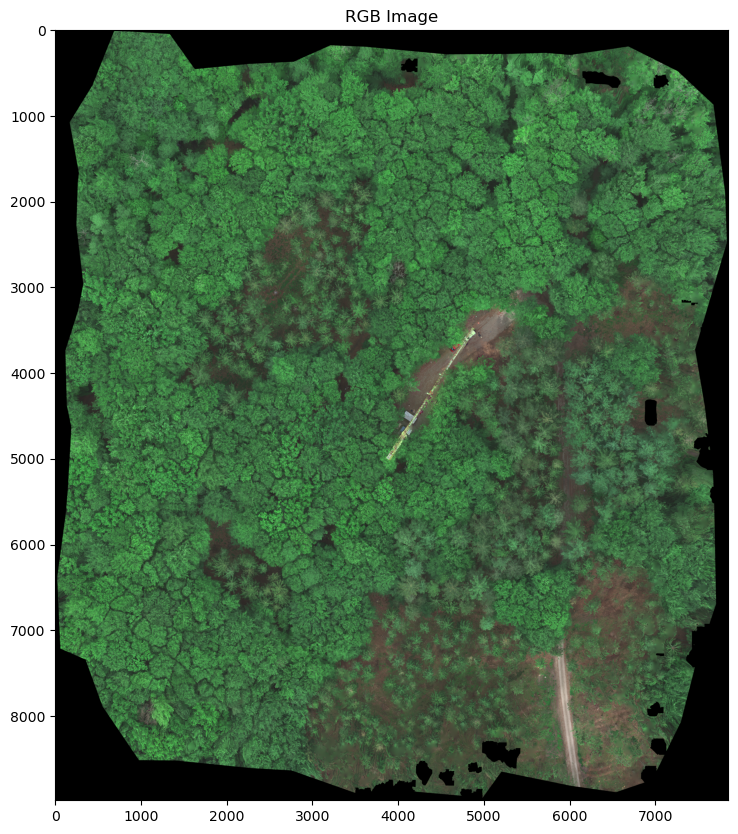

In [36]:
# SCHRITT 2: RGB-DATEN EINLADEN 
uav_image = '20230525_Demmin_Altum_orthomosaic_RGB_3cm_georefGCP.tif'
raster = rasterio.open(uav_image)
type(raster)

# Band 1, 2 und 3 (R, G, B) lesen
band1 = raster.read(1)
band2 = raster.read(2)
band3 = raster.read(3)

# Stapeln der Bänder, um ein RGB-Bild zu erstellen
rgb = np.dstack((band1, band2, band3))

# Raster plotten
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('RGB Image')
plt.axis()  # Achsen ausblenden
plt.show()

In [3]:
# SCHRITT 3: ZENTROIDE EINLADEN UND OUTPUT FOLDER ERSTELLEN
shapefile_centroids = 'centroid_1408.shp'
shapefile_polygons = 'Kronendelinierung_1408.shp'
output_folder = 'Output_Min_Polygon_Size'
uav_image = '20230525_Demmin_Altum_orthomosaic_RGB_3cm_georefGCP.tif'
polygons = gpd.read_file(shapefile_polygons)
centroids = gpd.read_file(shapefile_centroids)
os.makedirs(output_folder, exist_ok=True)

# SCHRITT 4: GRÖßE DES KLEINSTEN POLYGONS BESTIMMEN
min_polygon_area = float('inf')
min_width = min_height = 0

for polygon in polygons.geometry:
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    area = width * height
    if area < min_polygon_area:
        min_polygon_area = area
        min_width = width
        min_height = height

print(f"Größe des kleinsten Polygons: {min_width} x {min_height} Meter")

# SCHRITT 5: DROHNENBILD EINLADEN UND BOUNDING BOX ERSTELLEN
with rasterio.open(uav_image) as src:
    for idx, centroid in centroids.iterrows():
        tree_name = centroid['Baumart'] # Die Baumart wird aus der Shapefile der Zentroide aus der Spalte "Baumart" entnommen
        
        minx = centroid.geometry.x - min_width / 2
        miny = centroid.geometry.y - min_height / 2
        maxx = centroid.geometry.x + min_width / 2
        maxy = centroid.geometry.y + min_height / 2

        # Bild ausschneiden
        window = from_bounds(minx, miny, maxx, maxy, src.transform)
        out_image = src.read(window=window)

        # Dateinamen mit Baumart und Index erstellen und im Output Folder speichern
        output_path = os.path.join(output_folder, f"{tree_name}_{idx}.tif")

        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": src.window_transform(window)})

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

print("Alle Ausschnitte basierend auf der Größe des kleinsten Polygons wurden erfolgreich gespeichert.")

Größe des kleinsten Polygons: 4.008399999700487 x 4.03490000218153 Meter
Alle Ausschnitte basierend auf der Größe des kleinsten Polygons wurden erfolgreich gespeichert.


##### Bildgröße überprüfen und ein zufälliges Bild anzeigen

Um sicherzustellen, dass unser neuronales Netzwerk ordnungsgemäß funktioniert, ist es wichtig, dass alle Bilder die gleiche Auflösung haben. Daher überprüfen wir, ob alle Bilder im Ausgabeordner (Output Folder) die gleiche Auflösung besitzen. Diese Überprüfung garantiert, dass unser Modell konsistente Eingaben erhält und vermeidet mögliche Probleme während des Trainings.

Zusätzlich lassen wir ein RGB-Bild sowie die einzelnen RGB-Kanäle (Rot, Grün und Blau) eines zufälligen Bildes anzeigen. Diese Visualisierung dient dazu, die korrekte Darstellung der Bilder und die Informationserhaltung in den RGB-Kanälen zu überprüfen.

In [4]:
# Überprüfen, ob alle Bilder die selbe Auflösung haben.

# Alle Bilder im Output Folder überprüfen
def check_image_resolutions(directory, expected_size=(128, 129)):
    all_images_correct = True
    incorrect_images = []
    
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            file_path = os.path.join(directory, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                if (width, height) != expected_size:
                    all_images_correct = False
                    incorrect_images.append((filename, width, height))
    
# Falls nicht alle Bilder die gewünschte Auflösung haben, diese Bilder aufzählen.
    if all_images_correct:
        print("Alle Bilder haben die erwartete Auflösung von {}x{}.".format(*expected_size))
    else:
        print("Einige Bilder haben nicht die erwartete Auflösung von {}x{}:".format(*expected_size))
        for img_info in incorrect_images:
            print(f"Bild: {img_info[0]}, Größe: {img_info[1]}x{img_info[2]}")

# Output Folder
output_dir = 'Output_Min_Polygon_Size'

# Auflösung überprüfen
check_image_resolutions(output_dir)

Alle Bilder haben die erwartete Auflösung von 128x129.


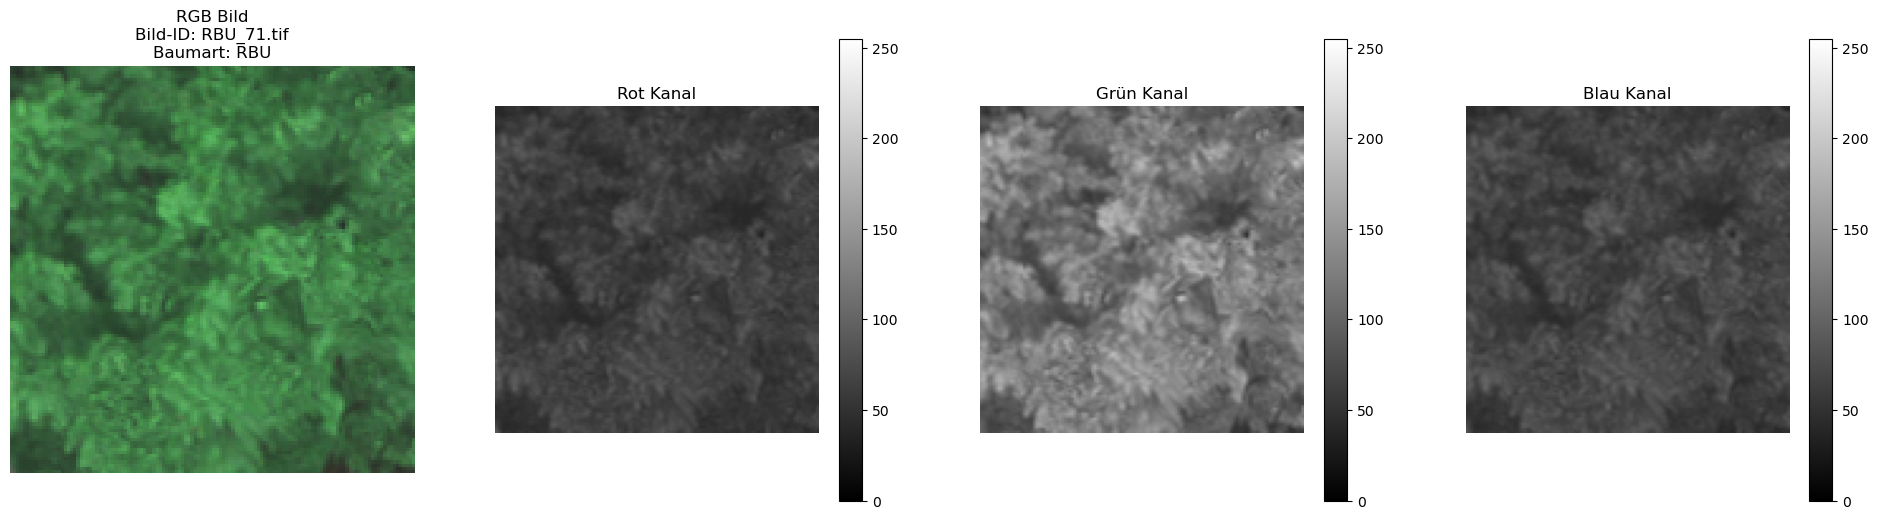

In [5]:
# Ein zufälliges Bild in RGB sowie Rot, Grün und Blau anzeigen

# Alle Bilder aus dem Ordner werden in eine Liste "images" geladen 
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            file_path = os.path.join(folder, filename)
            with Image.open(file_path) as img:
                img = img.convert('RGB')  # Hiermit wird sichergestellt, dass das Bild im RGB-Modus vorliegt
                images.append((np.array(img), filename))
    return images

# RGB-Bild sowie die RGB-Kanäle eines zufälligen Bildes anzeigen 
def show_random_image_channels(images):
    if not images:
        print("Keine Bilder im Ordner gefunden.")
        return
  
    random_index = random.randint(0, len(images) - 1)
    image, filename = images[random_index]
    
    # Baumart aus den Dateinamen extrahieren
    baumart = filename[:3]
    
    # 4 Unterplots mit RGB-Bild sowie den RGB-Kanälen
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    channels = ['Rot', 'Grün', 'Blau']
    
    axes[0].imshow(image)
    axes[0].set_title(f'RGB Bild\nBild-ID: {filename}\nBaumart: {baumart}')
    axes[0].axis('off')
    
    for i, (ax, color) in enumerate(zip(axes[1:], channels)):
        cax = ax.imshow(image[:, :, i], cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'{color} Kanal')
        ax.axis('off') 
        fig.colorbar(cax, ax=ax, orientation='vertical')
    
    plt.show()

# Bilder aus dem Ordner laden
images = load_images_from_folder(output_dir)

# RGB-Bild und die Kanäle eines zufälligen Bildes anzeigen
show_random_image_channels(images)


#### Ausgeschnittene Bilder für das Multi Layer Perceptron vorbereiten
Um mit den ausgeschnittenen Bildern jeder Baumkrone weiterarbeiten zu können, müssen wir sowohl die Bilder als auch die zugehörigen Baumarten (Labels) in NumPy-Arrays umwandeln. Dabei ist es wichtig, dass die RGB-Kanal-Informationen der Bilder erhalten bleiben, da unser Modell die Klassifikation auf Basis dieser RGB-Werte vornehmen wird. Der Alpha-Kanal ist für die Klassifizierung nicht relevant und wird daher nicht berücksichtigt.

Nach der Umwandlung haben wir zwei Arrays:

"*X*" enthält die ausgeschnittenen Bilder und hat vier Dimensionen: die Anzahl der Bilder, die Höhe, die Breite und die Anzahl der Kanäle (RGB-Kanäle) jedes Bildes.

"*y*" repräsentiert die Labels der Bilder und hat nur eine Dimension, die die Anzahl der Labels angibt.
Im nächsten Schritt wandeln wir die Labels in numerische Werte um. Dazu verwenden wir den *LabelEncoder*, um die kategorialen Labels in numerische Werte von 0 bis 4 zu konvertieren. Für den MLPClassifier ist eine One-Hot-Encoding der Labels nicht erforderlich, da der Klassifikator direkt mit den numerischen Label-Werten arbeiten kann.

In [6]:
## Erstelle 2 Arrays: X für Bilder und y für Labels
# Pfad zum Ordner mit den Bildern
base_path = 'Output_Min_Polygon_Size'

# 2 leere Listen erstellen für die Bilder (X) und die Labels (y)
X = []
y = []

# Alle Bilder im Ordner werden durchgegangen
for img_name in os.listdir(base_path):
    # Versteckte Dateien und Ordner ignorieren
    if img_name.startswith('.'):
        continue
    
    img_path = os.path.join(base_path, img_name)
    
    # Überprüfen, ob es sich tatsächlich um eine Datei handelt
    if not os.path.isfile(img_path):
        continue
    
    # Label aus dem Dateinamen extrahieren
    label = img_name[:3]  
    
    # Bild laden und in RGB konvertieren (Der Alpha-Kanal wird dabei entfernt)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)
    
    # Listen mit Bildern und Labeln füllen
    X.append(img)
    y.append(label)

# Die Bilder werden in einen NumPy-Array, einen 4-D-Array umgewandelt
# Die Labels werden einen 1-D-Array umgewandelt
X = np.array(X)
y = np.array(y)

# X (Die Bilder), ein 4-D-Array, haben die Form (Anzahl der Bilder, Höhe, Breite, Anzahl der Kanäle)
# Y (Die Labels), ein 1-D-Array, haben die Form (Anzahl der Labels)
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (192, 129, 128, 3)
Shape of y: (192,)


In [7]:
#Anzahl und Verteilung der Labels überprüfen
label_counts = Counter(y)
print("Verteilung der Labels im gesamten Datensatz:", label_counts)

Verteilung der Labels im gesamten Datensatz: Counter({'RBU': 93, 'GDG': 35, 'GFI': 22, 'ELA': 21, 'SEI': 21})


In [8]:
# Mithilfe des LabelEncoders transformieren wir die Labels in numerische Labels, damit unser Multi Layer Perceptron damit arbeiten kann
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Die einzigartigen Labels anzeigen
print("Einzigartige numerische Labels:", np.unique(y_numeric))

# Die Zuordnung zwischen den Original-Labels und den numerischen labels überprüfen
for original_label, numeric_label in zip(np.unique(y), np.unique(y_numeric)):
    print(f"Label '{original_label}' ist kodiert als {numeric_label}")

Einzigartige numerische Labels: [0 1 2 3 4]
Label 'ELA' ist kodiert als 0
Label 'GDG' ist kodiert als 1
Label 'GFI' ist kodiert als 2
Label 'RBU' ist kodiert als 3
Label 'SEI' ist kodiert als 4


#### Stratified Sampling und Train-Test Split
Aufgrund der begrenzten Stichprobengröße von 192 Bildern und der ungleichen Verteilung der Klassen (Baumarten) möchten wir sicherstellen, dass jede Klasse in den Trainings- und Testdatensätzen gleichmäßig vertreten ist. Daher verwenden wir eine stratifizierte Zufallsauswahl (stratified random sampling), um die Anzahl der Bilder pro Klasse zu vereinheitlichen (Singh & Mangat 1996). Da einige Klassen (wie GFI, ELA und SEI) nur etwas mehr als 20 Bilder umfassen, legen wir die Anzahl der Bilder pro Klasse auf 20 fest.

Die ausgewählten Bilder werden anschließend in NumPy-Arrays umgewandelt und in Trainings- (80 %) und Testdatensätze (20 %) aufgeteilt. Dadurch haben wir für jede Klasse im Trainingsdatensatz 16 Bilder um im Testdatensatz 4 Bilder.

Zur Überprüfung der Datenaufteilung zeigen wir je drei zufällige Bilder aus dem Trainings- und Testdatensatz an, einschließlich ihres Indexes, Original-Labels und numerischen Labels. Dies ermöglicht uns eine visuelle Kontrolle der Datenverteilung und Sicherstellung der korrekten Zuordnung.

In [9]:
# Um sicherzustellen, dass wir eine gleiche Anzahl an Bilder für jede Klasse (Baumart) im Trainings- und Testdatensatz haben
# wird eine stratifizierte Sampling-Methode gewählt.
# Da wir von einigen Klassen (GFI, ELA und SEI) nur knapp über 20 Samples haben, legen wir unsere Samplegröße pro Klasse auf 20 fest.
samples_per_class = 20

# Leere Listen für die stratifizierten Bilder und Labels erstellen
selected_X = []
selected_y = []

# Über jede Klasse iterieren und züfällig die benötigte Anzahl von Proben auswählen
unique_classes = np.unique(y_numeric)
for class_label in unique_classes:
    # Indizes finden, die zu der Klasse gehören
    indices = np.where(y_numeric == class_label)[0]
    # Zufällige Anzahl von gewünschten Proben auswählen
    selected_indices = np.random.choice(indices, samples_per_class, replace=False)
    selected_X.extend(X[selected_indices])
    selected_y.extend(y_numeric[selected_indices])

# Die Listen werden wieder in NumPy-Arrays umgewandelt
selected_X = np.array(selected_X)
selected_y = np.array(selected_y)

# StratifiedShuffleSplit wird benutzt, um die Daten in Trainungs- und Testsets aufzuteilen
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(selected_X, selected_y):
    X_train, X_test = selected_X[train_index], selected_X[test_index]
    y_train, y_test = selected_y[train_index], selected_y[test_index]

# Die Form der NumPy-Arrays kennen wir bereits 
# Diesmal gibt es 80 Bilder im Testdatensatz und 20 Bilder im Trainingsdatensatz
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (80, 129, 128, 3)
Shape of X_test: (20, 129, 128, 3)
Shape of y_train: (80,)
Shape of y_test: (20,)


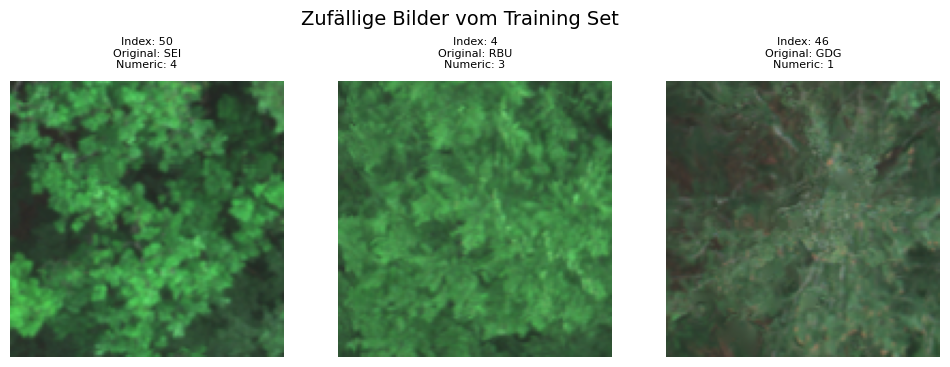

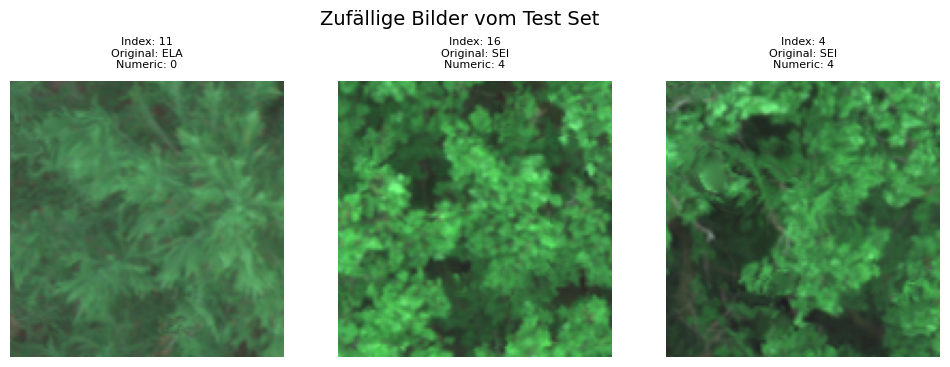

In [10]:
# Darstellung von je drei zufälligen Bildern aus dem Trainings- und Testdatensatz

# Funktion erstellen um die Bilder mit dem Index, dem Original-Label und dem numerischen Label anzuzeigen 
def show_random_images(X_data, y_data, encoder, dataset_name, num_images=3):
    
    # Zufällig ausgewählte Indizes für die Vorschau generien
    indices = random.sample(range(len(X_data)), num_images)

    # Plot erstellen
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    # Zufällige Bilder und deren Labels anzeigen
    for i, idx in enumerate(indices):
        img = X_data[idx]
        # Ursprüngliche Label für das Bild holen
        original_label = encoder.inverse_transform([y_data[idx]])[0]
        # Numerische Label für das Bild holen
        numeric_label = y_data[idx]
        
        # Subtitle für jedes Bild erstellen
        axes[i].imshow(img)
        axes[i].set_title(f"Index: {idx}\nOriginal: {original_label}\nNumeric: {numeric_label}", fontsize=8, pad=10)
        axes[i].axis('off')

    # Layout anpassen, damit der Titel nicht die Plots überdeckt
    plt.subplots_adjust(top=0.8)  
    plt.suptitle(f'Zufällige Bilder vom {dataset_name} Set', fontsize=14)
    plt.show()

# LabelEncoder intialisieren, um die Original-Labels zu erstellen
label_encoder = LabelEncoder()
label_encoder.fit(y)

# 3 zufällige RGB-Bilder aus dem Trainings- und Testdatensatz anzeigen
show_random_images(X_train, y_train, label_encoder, 'Training')
show_random_images(X_test, y_test, label_encoder, 'Test')

#### Feature Scaling
Um sicherzustellen, dass unser neuronales Netzwerk effektiv mit den RGB-Werten arbeiten kann, ist eine Standardisierung der Daten erforderlich. Dazu bringen wir die Werte der RGB-Kanäle auf einen Bereich zwischen 0 und 1. Um jedoch Nullwerte zu vermeiden, definieren wir einen kleinen Wert, 
𝜖 (Epsilon), den wir zu den niedrigsten RGB-Werten hinzufügen. Diese Vorgehensweise ermöglicht es uns, die Daten später gegebenenfalls logarithmisch zu transformieren und weiterhin mit den logarithmierten Daten zu arbeiten.

Zur Validierung der Standardisierung überprüfen wir die Wertebereiche jedes RGB-Kanals sowohl für den Trainings- als auch für den Testdatensatz. Dadurch stellen wir sicher, dass die Standardisierung korrekt durchgeführt wurde und die Daten konsistent sind.

In [11]:
## Normalisierung mit Vermeidung von 0 Werten, durch anhängen eines kleinen Wertes zur Null - Geeignet fürs logarithmieren

# ein kleiner Wert, hier Epsilon, wird generiert, um Nullwerte zu vermeiden
epsilon = 1e-6

# Min-Max Normalisierung mit Epsilon definieren
def normalize_with_epsilon(X, epsilon):
    X_min = np.min(X)
    X_max = np.max(X)
    return (X - X_min + epsilon) / (X_max - X_min + epsilon)

# Und auf den Test- und Trainingsdatensatz der Bilder anwenden. Für die Labels ist es natürlich nicht notwendig
X_train_normalized = normalize_with_epsilon(X_train, epsilon)
X_test_normalized = normalize_with_epsilon(X_test, epsilon)

In [12]:
# Wertebereich für jeden Kanal für den Trainingsdatensatz und den Testdatensatz überprüfen
for i, color in enumerate(['Rot', 'Grün', 'Blau']):
    print(f"{color} Min Value: {np.min(X_train_normalized[..., i])}")
    print(f"{color} Max Value: {np.max(X_train_normalized[..., i])}")
for i, color in enumerate(['Rot', 'Grün', 'Blau']):
    print(f"{color} Min Value: {np.min(X_test_normalized[..., i])}")
    print(f"{color} Max Value: {np.max(X_test_normalized[..., i])}")

Rot Min Value: 4.484304912626435e-09
Rot Max Value: 0.7264574003297875
Grün Min Value: 4.484304912626435e-09
Grün Max Value: 1.0
Blau Min Value: 4.484304912626435e-09
Blau Max Value: 0.578475338213115
Rot Min Value: 4.4247787414832795e-09
Rot Max Value: 0.508849559695356
Grün Min Value: 4.4247787414832795e-09
Grün Max Value: 1.0
Blau Min Value: 0.008849561907745301
Blau Max Value: 0.46460177228052313


In [13]:
# Zufälliges Bild aus dem Trainingsdatensatz auswählen
image_index = random.randint(0, X_train_normalized.shape[0] - 1)
# Min- und Max-Werte für jeden Kanals des zufälligen Bildes anzeigen lassen
print(f"Channel Min/Max Values for Image Index: {image_index}")
print(f"Rot Min: {np.min(X_train_normalized[image_index, :, :, 0])}, Max: {np.max(X_train_normalized[image_index, :, :, 0])}")
print(f"Grün Min: {np.min(X_train_normalized[image_index, :, :, 1])}, Max: {np.max(X_train_normalized[image_index, :, :, 1])}")
print(f"Blau Min: {np.min(X_train_normalized[image_index, :, :, 2])}, Max: {np.max(X_train_normalized[image_index, :, :, 2])}")


Channel Min/Max Values for Image Index: 35
Rot Min: 0.07174888308632789, Max: 0.4843049350479599
Grün Min: 0.11659193221259224, Max: 0.8789237673590863
Blau Min: 0.062780273261075, Max: 0.46188341048482773


#### Multi Layer Perceptron trainieren
Bevor wir unser neuronales Netzwerk erstellen und mit den Trainingsdaten trainieren, müssen wir zunächst die Trainings- und Testbilder (X_train und X_test) in ein 2D-Array umwandeln. Dies ist erforderlich, da unser neuronales Netzwerk Eingaben im 2D-Format erwartet. Durch den Einsatz der Funktion *reshape* werden die Pixelwerte jedes Bildes in einen eindimensionalen Vektor transformiert. Infolgedessen haben die Arrays X_train_flat und X_test_flat nur noch zwei Dimensionen: die Anzahl der Bilder und die Anzahl der Pixel pro Bild.

Wir verwenden den MLPClassifier für unser Modell, da es sich um ein Klassifikationsmodell handelt. Unser neuronales Netzwerk besteht aus zwei Schichten, wobei jede Schicht 64 Neuronen enthält. Bei der Verwendung von weniger Neuronen, wie etwa 8 oder 32 pro Schicht, zeigte sich, dass das Modell nicht ausreichend komplex war, um alle Klassen zuverlässig zu erkennen.

Als Aktivierungsfunktion haben wir "ReLU" (Rectified Linear Unit) gewählt, da sie sich bei Multiklassen-Klassifikationen als effektiv erwiesen hat. Der Parameter *alpha* beeinflusst den Grad der Regularisierung des Modells. Der MLPClassifier in der Scikit-Learn-Bibliothek verwendet standardmäßig L2-Regularisierung, bei der der Strafterm in der Kostenfunktion aus der Summe der Quadrate der Gewichtungen berechnet wird. Ein höherer alpha-Wert führt zu einer stärkeren Bestrafung großer Gewichtswerte, was das Modell vereinfacht. Wir haben *alpha* auf 0,01 festgelegt.

Die Batch-Größe, also die Anzahl der Trainingsbilder, die in einem Schritt verarbeitet werden, haben wir auf 40 gesetzt. Basierend auf der Loss-Kurve haben wir uns für 500 Iterationen entschieden, da wir für jeden Trainingsdurchlauf 2 Batches benötigen, was 250 Durchläufen entspricht. Die Lernrate (*learning_rate*) beeinflusst die Größe der Gewichtsanpassungen bei jedem Schritt des Lernprozesses. Diese liegt im Bereich von 0 bis 1. Eine höhere Lernrate führt zu größeren Sprüngen bei der Gewichtsanpassung nach jedem Durchlauf. Wir haben uns für eine niedrige Lernrate von 0,001 entschieden, um die Gewichtsanpassungen in kleinen, präzisen Schritten durchzuführen.

Die Accuracy-Metrik misst die allgemeine Genauigkeit des Modells, d. h., den Anteil der korrekt klassifizierten Instanzen über alle Klassen hinweg.

In [14]:
# MLPClassifier Modell zur Klassifizierung

# Reshape der Daten für den MLPClassifier, da unsere Daten in einem 4D Array sind, MLP aber einen 2D Array benötigt
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

# Modell definieren: MLPClassifier für Klassifizierungsaufgaben
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 64),  # 2 Schichten (hidden layers) mit je 64 Neuronen
    activation='relu',            # ReLU-Aktivierungsfunktion
    alpha=0.01,                 # Regularisierungsterm
    batch_size=40,               # Batch-Größe (Anzahl der Trainingsbeispiel die gleichzeitig in einem Schritt verarbeitet werden)
    learning_rate_init=0.001,
    max_iter=500,                 # Maximale Anzahl der Iterationen
    random_state=0                # Zufallsstartwert für Reproduzierbarkeit  
)

# Trainiere das Modell
mlp.fit(X_train_flat, y_train)

# Vorhersagen auf den Testdaten
y_pred = mlp.predict(X_test_flat)

# Evaluierung
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7000


##### Modellauswahl
Die Loss Curve zeigt die Veränderung des Loss-Werts (Fehlerrate) während des Trainingsprozesses an. Die Loss-Kurve ist ein Diagramm, das die Loss-Werte des Modells gegen die Anzahl der Trainings-Epochen aufträgt. Aufgrund der Loss-Kurve haben wir uns für 500 Iterationen bzw. 250 Epochen entschieden. 

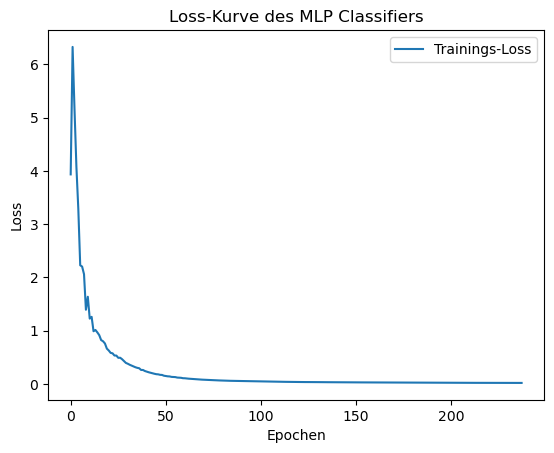

In [23]:
# Epochs Anzahl der Trainingsdurchläufe: Da Batch-Size = Größe der Trainingsdaten ist Iteration = Epoch
plt.plot(mlp.loss_curve_, label='Trainings-Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.title('Loss-Kurve des MLP Classifiers')
plt.legend()
plt.show()

#### Evaluierung des Modells
Um beurteilen zu können, wie präzise unser Modell die Bilder klassifizert hat, können wir uns einen Klassifizierungsbericht sowie eine Konfusionsmatrix ausgeben lassen. 
Der Klassifizierungsbericht gibt uns die Präzision, den Recall und den f1-Score für jede Klasse wieder.

Präzision: Anteil der positiv klassifizierten Instanzen, die tatsächlich positiv sind. Z. B. wie viele von der Baumart "ELA", die das Modell als "ELA" klassifiziert hat, waren wirklich "ELA".

Recall: Anteil der tatsächlich positiven Instanzen, die korrekt positiv klassifiziert worden sind. Z. B. Wie viele von den echten "ELAs" wurden wirklich als solche erkannt.

F1-Score: harmonisches Mittel von Precision und Recall. Bietet eine Balance zwischen diesen beiden Metriken. 

Macro avg: Durschnitt der Precision, Recall und F1-Score für alle Klassen, wobei jede Klasse gleich gewichtet wird. Weighted avg spielt keine Rolle, da unsere Klassen nicht unterschiedlich gewichtet sind. 

Für die Berechnung:

True positives (TP): Die Anzahl der Instanzen, die korrekt als positiv klassifiziert wurden.

False Negatives (FN): Die Anzahl der positiven Instanzen, die fälschlicherweise als negativ klassifiziert wurden.

False Positives (FP): Die Anzahl der negativen Instanzen, die fälschlicherweise als positiv klassifiziert wurden.

True Negatives (TN): Die Anzahl der Instanzen, die korrekt als negativ klassifiziert wurden.

Ein weiteres Werkzeug zur Bewertung der Leistung eines Klassifikationsmodell ist die Konfusionsmatrix. Sie bietet eine detaillierte Übersicht darüber, wie gut das Modell bei der Klassifizierung von Instanzen in verschiedenen Klassen abschneidet. Sie zeigt die Anzahl der korrekten und inkorrekten Klassifikationen, aufgeschlüsselt nach den tatsächlichen und vorhergesagten Klassen (Seol et al. 2023). 


Klassifizierungsbericht:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.33      0.25      0.29         4
           2       0.75      0.75      0.75         4
           3       0.80      1.00      0.89         4
           4       1.00      0.75      0.86         4

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.69        20
weighted avg       0.70      0.70      0.69        20



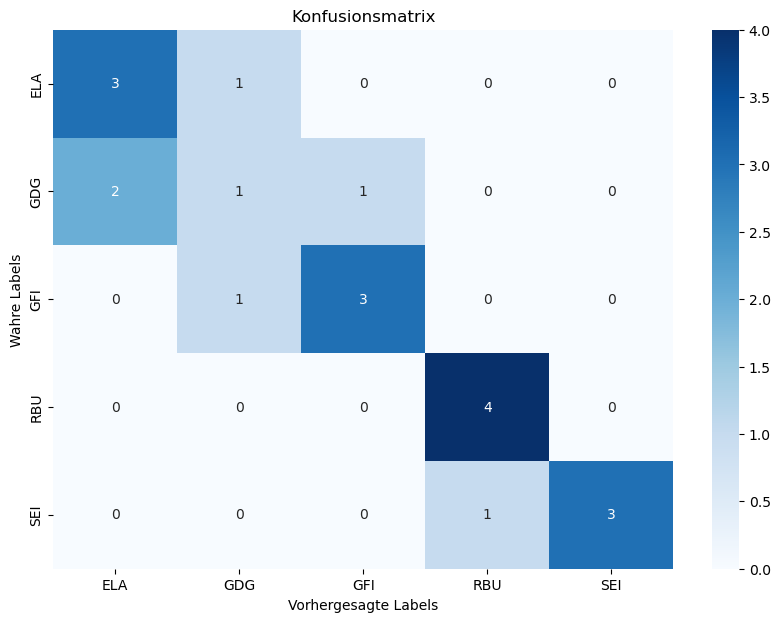

In [15]:
# Detaillierte Klassifikationsbewertung
report = classification_report(y_test, y_pred)
print("Klassifizierungsbericht:")
print(report)

# Eine Konfusionsmatrix erstellen
conf_matrix = confusion_matrix(y_test, y_pred)
# Konfusionsmaxtrix darstellen
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Konfusionsmatrix')
plt.show()


##### Vorhersagen des Modells anzeigen
Wir können uns für eine beliebige Anzahl von Bildern die Vorhersage des Modells sowie die tatsächlichen Labels anzeigen lassen.

In [17]:
# Erste 10 Vorhersagen darstellen
print("Erste 10 Vorhersagen und tatsächliche Labels:")
for i in range(10):
    print(f"Bild {i + 1} - Vorhersage: {y_pred[i]}, Tatsächliches Label: {y_test[i]}")

Erste 10 Vorhersagen und tatsächliche Labels:
Bild 1 - Vorhersage: 0, Tatsächliches Label: 0
Bild 2 - Vorhersage: 1, Tatsächliches Label: 1
Bild 3 - Vorhersage: 2, Tatsächliches Label: 2
Bild 4 - Vorhersage: 1, Tatsächliches Label: 1
Bild 5 - Vorhersage: 3, Tatsächliches Label: 4
Bild 6 - Vorhersage: 3, Tatsächliches Label: 0
Bild 7 - Vorhersage: 0, Tatsächliches Label: 0
Bild 8 - Vorhersage: 3, Tatsächliches Label: 3
Bild 9 - Vorhersage: 4, Tatsächliches Label: 3
Bild 10 - Vorhersage: 0, Tatsächliches Label: 1


#### Diskussion
Das in dieser Studie entwickelte Modell zur Klassifizierung von Baumkronen basiert auf einem Multilayer Perceptron (MLP) Classifier, das explizit mit RGB-Bildern trainiert wurde. Die für das Training verwendeten Bilder weisen eine Auflösung von 129x128 Pixeln auf. Nach der Vorverarbeitung wurden die Bilder in flache Vektoren umgewandelt, wobei jedes Bild zu einem eindimensionalen Vektor mit einer Länge von 49.536 Merkmalen (129x128x3 Kanäle für RGB) transformiert wurde. Diese Vektoren wurden dann zu einem zweidimensionalen Array (2D-Array) zusammengefasst, in dem jede Zeile einem Bild entspricht und die Dimensionen des Arrays (𝑋, 49536) betragen, wobei 𝑋 die Anzahl der Bilder ist.

Zusätzlich wurde eine Klassifizierung unter Verwendung der logarithmierten RGB-Werte durchgeführt. Allerdings ergab diese Vorgehensweise keine zufriedenstellenden Resultate, weshalb die entsprechenden Ergebnisse im weiteren Verlauf der Untersuchung nicht weiter vertieft wurden.

Der von uns verwendete Ansatz ist sehr leicht reproduzierbar und erfordert lediglich hochauflösende RGB-Luftbilder. Solide Artenkenntnisse sind bei der Interpretation der Baumkronen ausreichend, um die notwendigen Labels zu erstellen. Der Modellworkflow kann auf vielfältige Weise an abweichende Datengrundlagen angepasst zu werden. Hervorzuheben ist vor allem die Ausweitung der Klassen auf nicht berücksichtigte Baumarten sowie die Verwendung von weiteren Spektren (Nah-Infrarot, Kurzwelleninfrarot, Radar). 

Allgemein lässt sich sagen, dass unser Modell in den meisten Durchläufen Nadel- und Laubbäume gut auseinanderhalten konnte. D.h., dass die Klassen 0, 1 und 2 (Nadelbäume) nur selten fälschlicherweise den Klassen 3 und 4 (Laubbäume) zugeordnet wurden und vice versa. 

##### ethodische Schwächen
Aufgrund der begrenzten Stichprobengröße für einige Baumarten umfasst unser Trainingsdatensatz lediglich 80 Bilder, während der Testdatensatz 20 Bilder enthält. Zudem ist die Verteilung der Baumarten ungleichmäßig: Für die Baumart „RBU“ sind 93 Bilder vorhanden, während die Klassen „ELA“, „GFI“ und „SEI“ jeweils nur etwa 20 Bilder aufweisen. Diese Ungleichverteilung führt dazu, dass bei jedem Train-Test-Split nahezu identische Bilder für die drei weniger repräsentierten Klassen ausgewählt werden, während die Auswahl der Bilder für die Klasse „RBU“ variiert. Diese Variation bei der Auswahl der Bilder für „RBU“ trägt zur erheblichen Schwankung der Genauigkeit des Modells für diese Klasse zwischen den einzelnen Durchläufen bei.

Zusätzlich führt die geringe Anzahl von 20 Bildern pro Klasse dazu, dass die Accuracy-Metriken jeweils von vier Testbildern abhängig sind. Bei einer so geringen Anzahl ist es unvermeidbar, dass die zufällig bestimmten Bilder in manchen Durchläufen besonders stark vom eigentlichen spektralen Profil der jeweiligen Baumart abweichen. Diese Fragilität beeinträchtigt die Fähigkeit des Modells, eine konsistente und reproduzierbare Klassifikation zu erzielen. Infolgedessen variierte der Accuracy-Score unseres Modells erheblich zwischen 0.55 und 0.85. Aufgrund dieser starken Schwankungen in der Modellgenauigkeit ist es schwierig, allgemeingültige Aussagen über die Klassifikationsgenauigkeit einzelner Baumarten zu treffen. Insbesondere zeigte die Klasse „RBU“ im Vergleich zu den anderen Baumarten eine tendenziell geringere Genauigkeit sowohl in Bezug auf Precision als auch auf Recall, was durch die genannten Faktoren bedingt sein dürfte.

##### ukünftige Anwendung
Ein zukünftiges Ziel könnte es sein, das Studiendesign so anzupassen, dass Anwender*innen einen klassifizierten Kartenoutput auf Grundlage eines RGB-Inputs generieren können. Neben den Limitationen im Sampling, bedarf es dazu auch einer Überarbeitung der Modellarchitektur. Da unser Modell auf festgelegten Einzelbildern trainiert wurde, ist es auch nur auf Einzelbilder übertragbar. Um jedoch ganze Szenen mit vielen Bäumen zu klassifizieren, sollte ein geeigneteres Bildsegmentierungsmodell - idealerweise U-Net - verwendet werden. 

Wir haben dennoch eine Szenen-basierte Darstellung des Modelloutputs erstellt. Dazu haben wir in QGIS die Zentroide bisher nicht berücksichtigter Baumkronen als Punktlayer gesammelt. Das resultierende Shapefile haben wir anschließend in unseren "data"-Ordner geladen und von allen Zentroiden ausgehend Bounding-Boxes mit der bisher genutzten Größe erstellt und damit das Ausgangs-RGB ausgeschnitten. 

In [27]:
# Pfade zu den Dateien
shapefile_path = 'unlabeled.shp'
raster_path = '20230525_Demmin_Altum_orthomosaic_RGB_3cm_georefGCP.tif'
output_dir = 'Output_Cropped_Centroids'
os.makedirs(output_dir, exist_ok=True)

# Shapefile einlesen
centroids = gpd.read_file(shapefile_path)
centroids = centroids.to_crs(epsg=25833)
# Rasterbild öffnen
with rasterio.open(raster_path) as src:
    # Für jeden Centroid einen Ausschnitt erstellen
    for idx, centroid in centroids.iterrows():
        # Koordinaten des Zentroiden
        x, y = centroid.geometry.x, centroid.geometry.y
        
        # 4x4m Bounding Box um den Zentroiden erstellen
        # Hier gehe ich davon aus, dass die Koordinaten in Metern sind.
        # Ansonsten müsstest du den Maßstab anpassen.
        buffer_distance = 2  # 2m in jede Richtung
        minx, miny = x - buffer_distance, y - buffer_distance
        maxx, maxy = x + buffer_distance, y + buffer_distance

        # Bounding Box in Raster-Koordinaten umrechnen und Window erstellen
        window = from_bounds(minx, miny, maxx, maxy, src.transform)

        # Ausschnitt aus dem Rasterbild extrahieren
        clip = src.read(window=window)

        # Ausgabe-Dateinamen erstellen
        output_filename = os.path.join(output_dir, f'clip_{idx}.tif')

        # Das ausgeschnittene Raster speichern
        with rasterio.open(
            output_filename,
            'w',
            driver='GTiff',
            height=clip.shape[1],
            width=clip.shape[2],
            count=src.count,
            dtype=clip.dtype,
            crs=src.crs,
            transform=rasterio.windows.transform(window, src.transform)
        ) as dst:
            dst.write(clip)


Die insgesamt 107 Einzelbilder haben wir anschließend wie zuvor normalisiert. Mit dem bereits trainierten Modell haben wir diese Einzelbilder dann klassifiziert. Die vorhergesagten Labels haben wir dann als Spalte an die Zentroiden angehängt.  

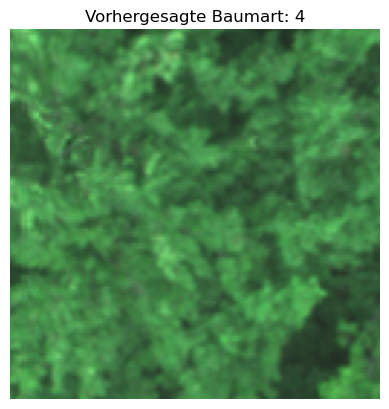

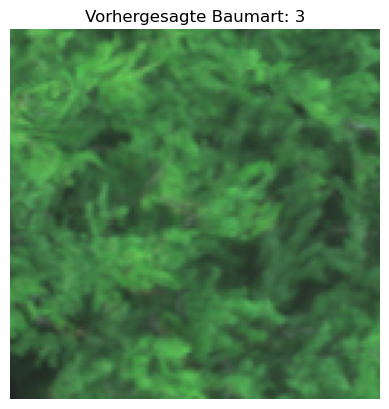

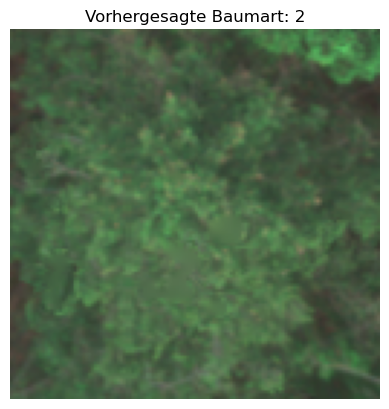

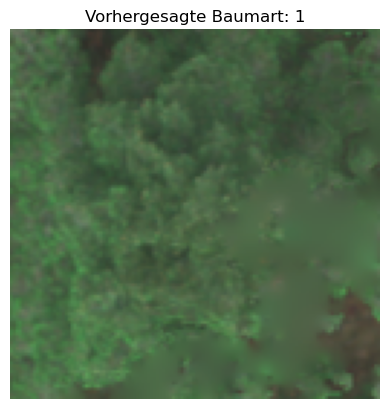

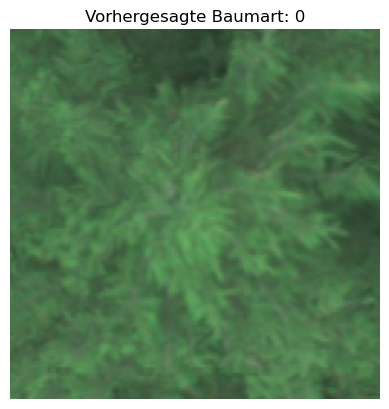

In [28]:
output_folder = 'Output_Cropped_Centroids'
# Bilder einlesen, vorverarbeiten und für Vorhersagen vorbereiten
image_paths = glob.glob(os.path.join(output_folder, '*.tif'))
X_new = []
image_filenames = []

epsilon = 1e-6

# Min-Max Normalisierung mit Epsilon definieren
def normalize_with_epsilon(X, epsilon):
    X_min = np.min(X)
    X_max = np.max(X)
    return (X - X_min + epsilon) / (X_max - X_min + epsilon)   
for image_path in image_paths:
     #Bild laden
    image = Image.open(image_path).convert("RGB")
    
     #Bildvorverarbeitung
    image = image.resize((128, 129))
    image_array = np.array(image)
    
    image_array = normalize_with_epsilon(image_array, epsilon) # Normalisierung
     #Bild in das richtige Format umwandeln
    image_flattened = image_array.flatten().reshape(1, -1)
    
     #Bildpfad für spätere Zuordnung speichern
    image_filenames.append(image_path)
    
     #Bild zur Liste hinzufügen
    X_new.append(image_flattened)

 # Alle Bilder zu einem NumPy-Array kombinieren
X_new = np.vstack(X_new)

# Vorhersagen treffen
predictions = mlp.predict(X_new)

# Erste 5 Bilder anzeigen
for i in range(min(5, len(image_paths))):
    image = Image.open(image_filenames[i]).convert("RGB")
    plt.figure()
    plt.imshow(image)
    plt.title(f"Vorhergesagte Baumart: {predictions[i]}")
    plt.axis('off')  
    plt.show()

In [72]:

# Shapefile mit den Zentroiden einladen
shapefile_path = 'unlabeled.shp'
centroids = gpd.read_file(shapefile_path)

# EPSG-Anpassung
centroids = centroids.to_crs(epsg=25833)

# 2. Mit dem LabelEncoder die numerischen Labels zurücktransformieren
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['ELA', 'GDG', 'GFI','RBU','SEI'])  # Beispiel: Passe diese Liste an deine Labels an
predictions_original_labels = label_encoder.inverse_transform(predictions)

# 3. Vorhersagen zu den Zentroiden hinzufügen
centroids['Baumart'] = predictions_original_labels

# 4. Shapefile speichern
output_shapefile_path = 'unlabeled_with_predictions.shp'
centroids.to_file(output_shapefile_path)

print(f"Erweiterte Shapefile gespeichert unter: {output_shapefile_path}")


Erweiterte Shapefile gespeichert unter: unlabeled_with_predictions.shp


Abschließend haben wir die Zentroiden der Baumkronen mit artspezifischen Symbolen in QGIS mit dem Drohnen-RGB visualisiert (siehe Abbildung 4). Die Ergebnisse sind erwartbar stark von der vorangegangenen zufälligen Stichprobennahme und dem daraus resultierenden Modellbias beeinflusst. 

![Ergebniskarte.png](Ergebniskarte.png)
***Abbildung 4***: Modellvorhersagen der Baumarten. 


Nach sorgfältiger Erweiterung des Trainingsdatensatzes durch zusätzliche Bilder und die Einbeziehung weiterer Baumarten könnte ein potenzielles Anwendungsgebiet in der automatisierten Erkennung von Baumarten in schwer zugänglichen Nadel- und Laubwäldern Mitteleuropas mittels Satellitenbildern liegen. Dies könnte zur präzisen Einschätzung und Überwachung des Baumbestandes in diesen Regionen beitragen.
_____________________________________________________________________________________________________________________________________________

### Fazit
Die Genauigkeit unseres Modells zeigte bedauerlicherweise signifikante Schwankungen zwischen den einzelnen Durchläufen. Diese Variabilität kann primär auf die begrenzte Stichprobengröße pro Klasse zurückgeführt werden. Trotz dieser Einschränkung erreichten wir jedoch in einigen Fällen Accuracy-Scores von über 0,8 und bestimmte Klassen wiesen eine vollständige Erkennung auf, was einem Recall-Wert von 1 entspricht. 

Durch die Anwendung einer Bounding Box zur Extraktion von Ausschnitten um Baumkronen herum lässt sich unser Modell effizient mit zusätzlichen Bilddaten trainieren. Der Trainingsprozess erfordert lediglich hochauflösende Luftbilder sowie die Koordinaten der Zentroiden jeder Baumkrone, um die notwendigen Bildausschnitte für das Training zu erstellen. Ein Beispiel für diese Methodik wäre die Nutzung des Baumkatasters des Berliner Grünflächeninformations- und -managementsystems in Kombination mit entsprechenden Satellitenbildern, die im späten Frühling oder Sommer aufgenommen wurden. Diese Vorgehensweise ermöglicht eine präzise und systematische Schulung des Modells zur Erkennung von Baumkronen. 

### Literatur

* Anzanello, M.J., Fogliatto, F.S. (2011): Learning curve models and applications: Literature review and research directions. International Journal of Industrial Ergonomics 41 (5), 573-583.

* Bento, Carolina (2021): Multilayer Perceptron Explained with a Real-Life Example and Python Code: Sentiment Analysis. Towards Data Science (Medium). https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141.

* Hinton, Geoffrey E. (1989): Connectionist learning procedures. Artificial intelligence 40.1, 185-234.

* Kingma, D. P., and Ba, J. L. (2014): “ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION.” CoRR, abs/1412.6980, arxiv.org/abs/1412.6980.

* McCulloch, W.S., Pitts, W. (1943): A logical calculus of the ideas immanent in nervous activity. Bulletin of Mathematical Biophysics 5, 115–133.

* Rosenblatt, F. (1957): The Perceptron, a Perceiving and Recognizing Automaton Project Para. Cornell Aeronautical Laboratory 85, 460–461.

* Scikit-learn (2024): precision_recall_fscore_support - Online, URL: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html [Zugriff 20.08.2024]

* Seol, D.H., Choi, J.E., Kim, C.Y., Hong, S.J. (2023): Alleviating Class-Imbalance Data of Semiconductor Equipment Anomaly Detection Study. Electronics, 2023, 12, 585. 

* Singh, R., Mangat, N. S. (1996): Elements of Survey Sampling. Volume 15. Springer-Sciene+Business Media, B.V., 388 S.